## Use this notebook after you've trained sufficiently your SiameseNet



#### Accept the results with a pinch of salt. We don't really know why your signature will be most similar to your doppelgänger, it's hard to interpret model's "logic". The results can also be a result of an overfit or similar texture\clothes\position of your mouth and many more...

In [1]:
from tqdm import tqdm
import numpy as np
import os
from keras.models import load_model, Model
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from utils import get_faces_df

import matplotlib.pyplot as plt
%matplotlib inline

PATH = './'

df_train, df_valid, df_test, partitions = get_faces_df(PATH)
df_all = df_train.append(df_valid.append(df_test))

model = load_model('siamese_xception.h5')

inp = model.input[0]
base_model = model.layers[3]
emb_model = model.layers[4]

# The original model requiers triplet input. In the inference model we want to pass only one single image
# Model's output will be image's embedding vector
# We now can compare the "signature" of the test image to the embeddings of the whole dataset and find the most similar one

infer_model = Model(inp, emb_model(base_model(inp)))

Using TensorFlow backend.


Train images: 162770
Validation images: 19867
Test images: 19962
Instructions for updating:
Colocations handled automatically by placer.


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("anchor_1:0", shape=(?, 2048), dtype=float32) at layer "anchor". The following previous layers were accessed without issue: []

### Create or load embeddings for the dataset

In [2]:
if os.path.isfile('emb_celebrities.npy'):
    embeddings = np.load('emb_celebrities.npy')
else:
    img_files = df_all['image'].values
    embeddings = np.zeros((len(img_files), 128))
    for i, file in enumerate(tqdm(df_all['image'].values)):
        img = plt.imread(PATH + 'img_align_celeba/{}'.format(file))
        img = preprocess_input(img)
        preds = infer_model.predict(img[None])[0]
        embeddings[i] = preds
    np.save('emb_celebrities.npy', embeddings)

## Display doppelgänger of all images that are in 'test_imgs' folder
It will display your image, with 2 most similar celebrities to you and the least similar one.

C:\Users\jgolb\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


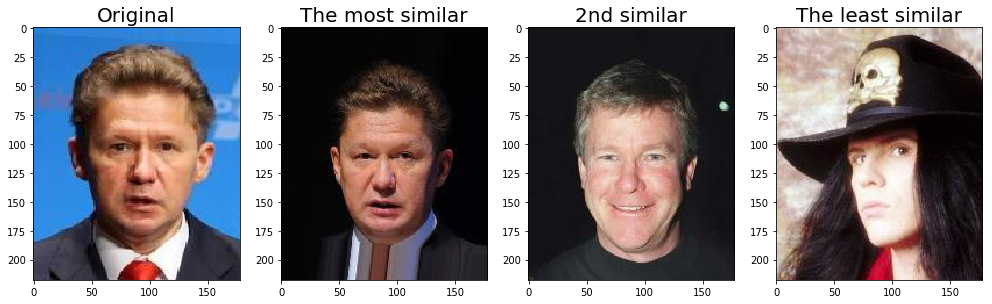

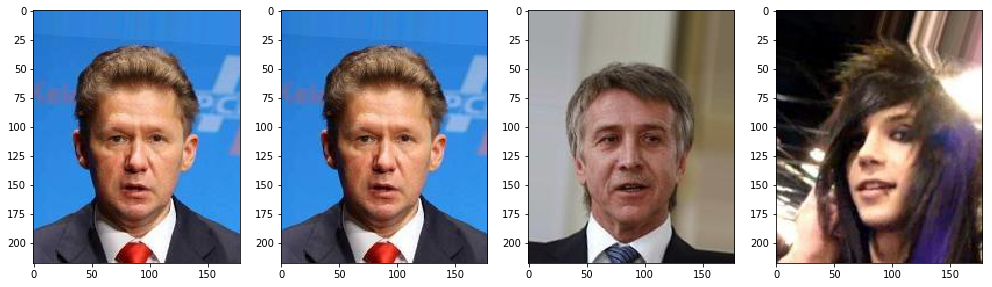

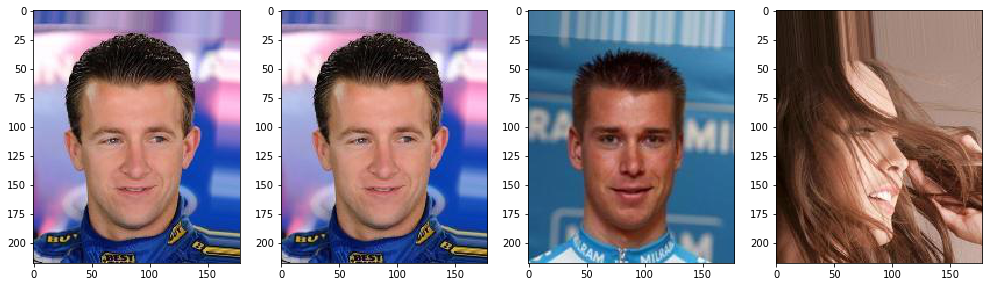

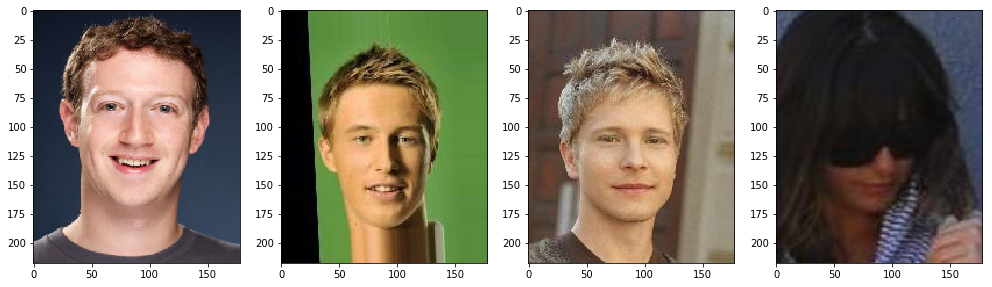

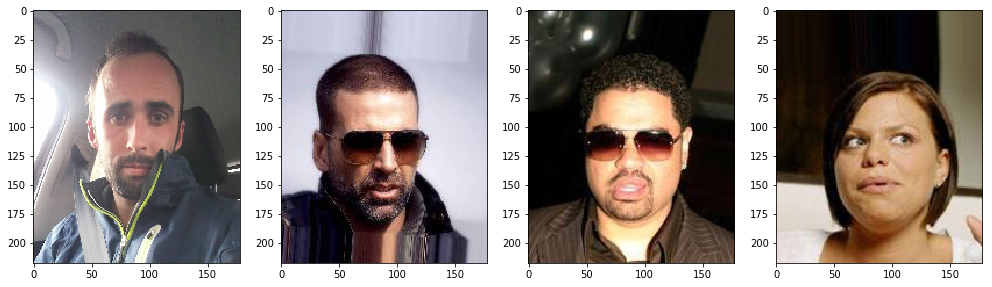

In [5]:
imgs = sorted(os.listdir('test_imgs/'))
imgs = list(set(imgs).difference(['.ipynb_checkpoints']))
celeb_images = df_all['image'].values

for k, file in enumerate(imgs):
    img = image.load_img('test_imgs/{}'.format(file)).resize((178, 218))
    img = image.img_to_array(img).astype('uint8')
    
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    pred = infer_model.predict(x)
    res = -np.matmul(embeddings, pred.T)
    sorted_similar = np.argsort(res, axis=0)
    plt.figure(figsize=(17,10))
    if not(k):
        plt.subplot(1,4,4)
        plt.title('The least similar', fontsize=20)
        plt.subplot(1,4,3)
        plt.title('2nd similar', fontsize=20)
        plt.subplot(1,4,2)
        plt.title('The most similar', fontsize=20)
        plt.subplot(1,4,1)
        plt.title('Original', fontsize=20)
    plt.subplot(1,4,1)
    plt.imshow(img)
    for i, s in enumerate(sorted_similar[:2]):
        img = image.load_img(PATH + 'img_align_celeba/{}'.format(celeb_images[s][0]))
        x = image.img_to_array(img)
        plt.subplot(1,4,i+2)
        plt.imshow(x.astype('uint8'))
    img = image.load_img(PATH + 'img_align_celeba/{}'.format(celeb_images[sorted_similar[-1]][0]))
    x = image.img_to_array(img)
    plt.subplot(1,4,4)
    plt.imshow(x.astype('uint8'))